In [2]:
import io
import numpy as np
import pandas as pd
from scipy.signal import butter, lfilter
import librosa

In [3]:
db_file_name = "batcallsv14.db"
table_name = "batcalls"

In [4]:
data = pd.read_sql(table_name, f"sqlite:///{db_file_name}")
data = data.groupby('bat').head(300)
data['arr'] = data['arr'].map(lambda bytes: np.load(io.BytesIO(bytes)))
data['arr'] = data['arr'].map(lambda call: call.astype(np.float32) / 2.0**(16-1))

def butter_bandpass(lowcut, highcut, fs, order=5):
  nyq = 0.5 * fs
  low = lowcut / nyq
  high = highcut / nyq
  b, a = butter(order, [low, high], btype='band')
  return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
  b, a = butter_bandpass(lowcut, highcut, fs, order=order)
  y = lfilter(b, a, data)
  return y

def fourier(data):
  stft = np.abs(librosa.stft(data, n_fft=512, hop_length=32))
  stft = 10 * np.log10(stft)
  stft = np.nan_to_num(stft)

  stft = (stft - np.min(stft)) / (np.max(stft) - np.min(stft))
  stft = np.reshape(stft, (257, 138, 1))
  stft = stft[:256, -128: , :]
  return stft

data['arr'] = data['arr'].map(lambda call: butter_bandpass_filter(call, 1500, 12000, 44100, 5))
data['arr'] = data['arr'].map(lambda call: (call - np.mean(call)) / np.std(call))
data['arr'] = data['arr'].map(lambda call: fourier(call))

/tmp/ipykernel_3667/256029850.py:20: RuntimeWarning: divide by zero encountered in log10
  stft = 10 * np.log10(stft)


In [12]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import LeaveOneOut

import matplotlib.pyplot as plt

In [7]:
X = np.concatenate(data['arr'].values).reshape(-1, 256, 128, 1)
print(X.shape)
print(X)

y = data['target']
print(y.shape)
print(y)

(5700, 256, 128, 1)
[[[[0.53835804]
   [0.53948557]
   [0.54231415]
   ...
   [0.64859158]
   [0.65782417]
   [0.66292837]]

  [[0.50813038]
   [0.50576234]
   [0.49896001]
   ...
   [0.65152788]
   [0.65956271]
   [0.66372559]]

  [[0.36563915]
   [0.36992238]
   [0.4328372 ]
   ...
   [0.65235068]
   [0.66057541]
   [0.66497807]]

  ...

  [[0.14172296]
   [0.16243762]
   [0.14479585]
   ...
   [0.62428213]
   [0.63279612]
   [0.63737375]]

  [[0.1416125 ]
   [0.16234285]
   [0.14464246]
   ...
   [0.62427632]
   [0.63279125]
   [0.63736848]]

  [[0.14154611]
   [0.16228695]
   [0.14454895]
   ...
   [0.62427359]
   [0.63278792]
   [0.63736611]]]


 [[[0.57025891]
   [0.55897285]
   [0.55574293]
   ...
   [0.66598872]
   [0.67428594]
   [0.67874864]]

  [[0.52802476]
   [0.54934378]
   [0.55315452]
   ...
   [0.66854439]
   [0.6758587 ]
   [0.67975462]]

  [[0.47855001]
   [0.49300669]
   [0.50699794]
   ...
   [0.6694032 ]
   [0.67687609]
   [0.68078308]]

  ...

  [[0.30204088]
   

In [6]:
X_dim = X.reshape(9067,-1)
print(X_dim.shape)

y_dim = data['target']
print(y_dim.shape)

NameError: name 'X' is not defined

In [8]:
pca_2d = PCA(2)
X_2d = pca_2d.fit_transform(X_dim)
print(pca_2d.explained_variance_ratio_)

pca_3d = PCA(3)
X_3d = pca_3d.fit_transform(X_dim)
print(pca_3d.explained_variance_ratio_)

[0.57155131 0.07549765]
[0.57155131 0.07549765 0.04719399]


/tmp/ipykernel_3458/1078713525.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
/tmp/ipykernel_3458/1078713525.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  c_map = plt.cm.get_cmap('jet', 19)


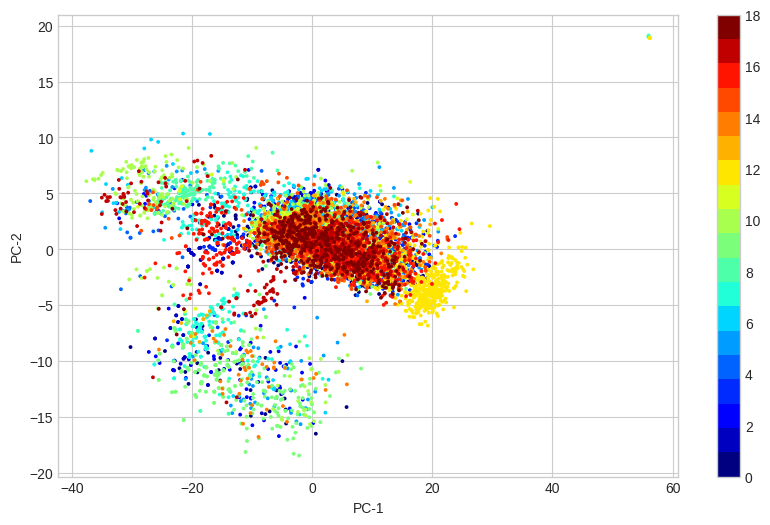

In [9]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (10,6))
c_map = plt.cm.get_cmap('jet', 19)
plt.scatter(X_2d[:, 0], X_2d[:, 1], s = 3,
            cmap = c_map , c = y_dim)
plt.colorbar()
plt.xlabel('PC-1') , plt.ylabel('PC-2')
plt.show()

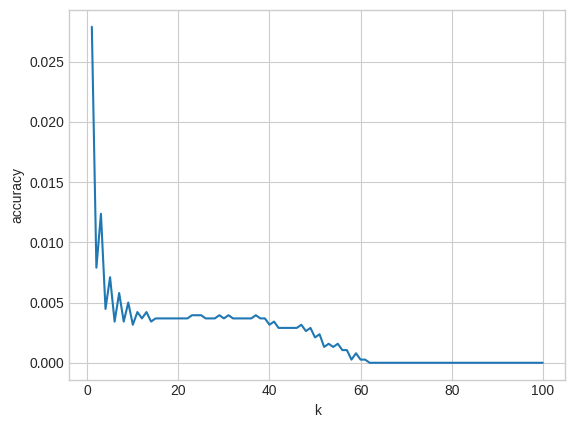

In [24]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_validate

k = range(1, 101)
scores_2d_knn_cv = []

for n_neighbors in k:
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    scores = cross_validate(knn, X_2d, y)
    scores_2d_knn_cv.append(np.mean(scores["test_score"]))

plt.plot(k, scores_2d_knn_cv)
plt.xlabel("k")
plt.ylabel("accuracy")
plt.show()

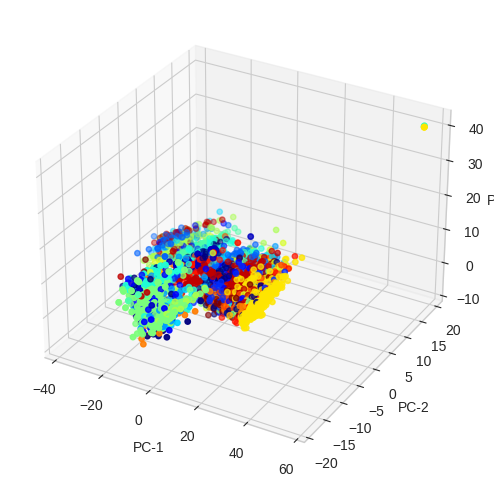

In [10]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(projection='3d')

ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], s = 15,
            cmap = c_map , c = y_dim)

ax.set_xlabel('PC-1')
ax.set_ylabel('PC-2')
ax.set_zlabel('PC-3')

plt.show()

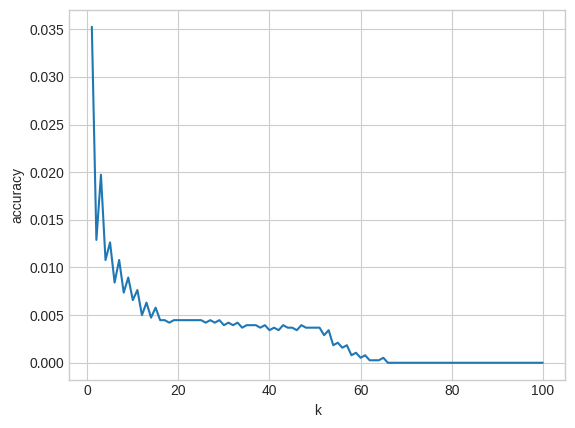

In [25]:
k = range(1, 101)
scores_3d_knn_cv = []

for n_neighbors in k:
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    scores = cross_validate(knn, X_3d, y)
    scores_3d_knn_cv.append(np.mean(scores["test_score"]))

plt.plot(k, scores_3d_knn_cv)
plt.xlabel("k")
plt.ylabel("accuracy")
plt.show()

(256, 128, 1)


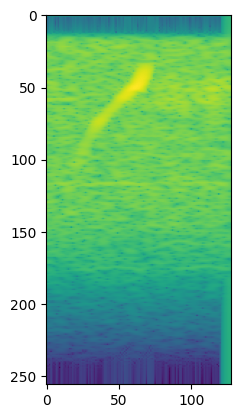

In [23]:
plt.imshow(X[0])

In [5]:
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import SGD #Stochastic Gradient Descent
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

2024-01-08 13:37:48.556596: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-08 13:37:48.920533: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-08 13:37:48.922337: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-08 13:37:50.687863: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [13]:
from IPython.display import clear_output
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show()
        
plot_losses = PlotLosses()

In [9]:
y = to_categorical(y)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

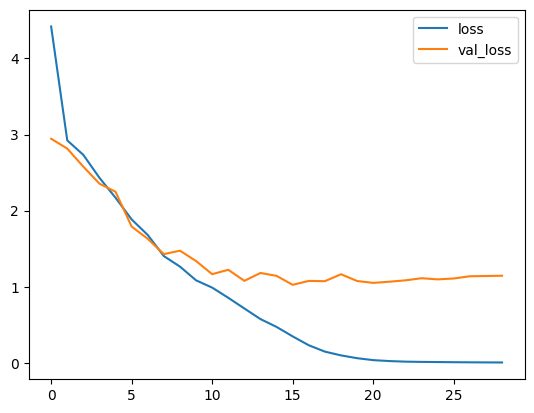

48/48 [==============================] - 119s 2s/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 1.1451 - val_accuracy: 0.6921
Epoch 30/100
22/48 [============>.................] - ETA: 1:30 - loss: 0.0049 - accuracy: 1.0000

KeyboardInterrupt: 

In [11]:
# Erstellen des Modells
model = Sequential()

# Hinzufügen von Convolutional Layers
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(256, 128, 1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Hinzufügen von Fully Connected Layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(19, activation='softmax'))

myAdam=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

# Kompilieren des Modells
model.compile(loss='categorical_crossentropy',
            optimizer=myAdam, 
            metrics=['accuracy'])

#Modell trainieren
historyCNN_model=model.fit(X_train, y_train, 
          validation_data=(X_test, y_test),                              
          epochs=20,
          batch_size=64,
          verbose=1,
          callbacks=[plot_losses])

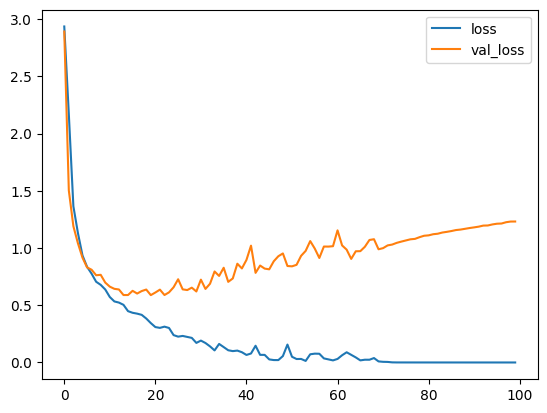

72/72 [==============================] - 32s 450ms/step - loss: 5.8655e-05 - accuracy: 1.0000 - val_loss: 1.2315 - val_accuracy: 0.8430


: 

In [14]:
model_vogl = Sequential()

model_vogl.add(Conv2D(16, (3,3), activation='relu', input_shape=(256, 128, 1)))
model_vogl.add(MaxPooling2D(2, 2))

model_vogl.add(Conv2D(32, (3,3), activation='relu'))
model_vogl.add(MaxPooling2D(2, 2))

model_vogl.add(Conv2D(64, (3,3), activation='relu'))
model_vogl.add(MaxPooling2D(2, 2))

model_vogl.add(Conv2D(64, (3,3), activation='relu'))
model_vogl.add(MaxPooling2D(2, 2))

model_vogl.add(Conv2D(64, (3,3), activation='relu'))
model_vogl.add(MaxPooling2D(2, 2))

model_vogl.add(Flatten())
model_vogl.add(Dense(512, activation='relu'))
model_vogl.add(Dense(19, activation='softmax'))

myAdam=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model_vogl.compile(loss='categorical_crossentropy',
            optimizer=myAdam, 
            metrics=['accuracy'])


historyCNN_model_vogl=model_vogl.fit(X_train, y_train, 
          validation_data=(X_test, y_test),                              
          epochs=100,
          batch_size=64,
          verbose=1,
          callbacks=[plot_losses])